In [65]:
import json
from pymongo import MongoClient
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from fedn import APIClient
from typing import List, Dict, Any
from fedland.database_models.experiment import experiment_store, Experiment 

# EXPERIMENT_ID = "672348e0b5b58473e1bba6aa"  # Balanced classes (not specified)
# EXPERIMENT_ID = "672350dd69ff8d1c3163f36a"  # Balanced classes
# EXPERIMENT_ID = "67288510cbeefa48e7882390"  # Balanced classes (No seed, fixed indexes)
# EXPERIMENT_ID = "6723576ce286058bcd2e5f5c"  # Imablanced
# EXPERIMENT_ID = "67286f34ddffa7950c8c8fd0"  # Imablanced (No seed)
# EXPERIMENT_ID = "67287eb68822ce8b7edca18c"  # Imablanced (No seed, fixed indexes)
# EXPERIMENT_ID = "67235cb4e286058bcd2e5f5d"  # Offsetting
# EXPERIMENT_ID = "672380095dc2f66ef4e6ff0b"    # 3 clients Imabalance

EXPERIMENT_ID = "67292bb90fe17824cc25b989"    # CIFAR-10 TEST
# EXPERIMENT_ID = "67294a2ef407ec33edbc2f13"    # CIFAR-100 TEST
# EXPERIMENT_ID = "6729e9ec280a81c198affa11"    # CIFAR-100 TEST (30 rounds)

FEDN_URL = "localhost"
FEDN_PORT = 8092
BATCHES=5
pd.set_option("display.max_columns", 100)

api = APIClient(FEDN_URL, FEDN_PORT)

def flatten_experiment_clients(experiment_clients: List[Dict[str, Any]]) -> pd.DataFrame:
    flattened_results = []
    
    for experiment in experiment_clients:
        client_index = experiment.get("client_index")
        experiment_id = experiment.get("experiment_id")
        
        for local_round in experiment.get("local_rounds", []):
            flattened_round = {
                "client_index": client_index,
                "experiment_id": experiment_id,
                **local_round  # Unpack all local round details
            }
            
            flattened_results.append(flattened_round)

    df = pd.DataFrame(flattened_results)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df: pd.DataFrame = df.sort_values(["client_index", "timestamp"])
    df["round_number"] = df.groupby("client_index").cumcount()
    df["path_norm_pct_change"] = df.groupby('client_index')['path_norm'].pct_change()
    
    return df
def flatten_nested_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    # parse string to dict
    if isinstance(df_copy['data'].iloc[0], str):
        df_copy['data'] = df_copy['data'].apply(json.loads)
    
    data_df = pd.json_normalize(df_copy["data"])
    df_copy = df_copy.drop("data", axis=1)
    flattened_df = pd.concat([df_copy.reset_index(drop=True), 
                            data_df.reset_index(drop=True)], 
                            axis=1)
    
    flattened_df["timestamp"] = pd.to_datetime(flattened_df["timestamp"])
    flattened_df = flattened_df.sort_values("timestamp")
    flattened_df["round_number"] = range(len(flattened_df))
    
    return flattened_df
def merge_federated_rounds(client_df: pd.DataFrame, global_df: pd.DataFrame) -> pd.DataFrame:
    clients = client_df.copy()
    global_results = global_df.copy()
    
    if not pd.api.types.is_datetime64tz_dtype(clients['timestamp']):
        clients['timestamp'] = pd.to_datetime(clients['timestamp']).dt.tz_localize('UTC')
    
    # Create round type column
    clients['round_type'] = 'local'
    global_results['round_type'] = 'global'
    
    # Rename columns to avoid conflicts
    global_results = global_results.rename(columns={
        'training_loss': 'global_train_loss',
        'training_accuracy': 'global_train_accuracy',
        'test_loss': 'global_test_loss',
        'test_accuracy': 'global_test_accuracy',
        'path_norm': 'global_path_norm'
    })
    
    clients = clients.rename(columns={
        'train_loss': 'local_train_loss',
        'train_accuracy': 'local_train_accuracy',
        'test_loss': 'local_test_loss',
        'test_accuracy': 'local_test_accuracy',
        'path_norm': 'local_path_norm'
    })
    
    merged_df: pd.DataFrame = pd.concat([clients, global_results], ignore_index=True)
    merged_df = merged_df.sort_values('timestamp')
    merged_df['absolute_round'] = range(len(merged_df))
    merged_df['cycle'] = (merged_df['round_type'] == 'global').cumsum()
    
    global_columns = [col for col in merged_df.columns if col.startswith('global_')]
    # merged_df[global_columns] = merged_df[global_columns].fillna(method='ffill')
    merged_df[global_columns] = merged_df[global_columns].ffill()
    
    return merged_df
def plot_path_norm_analysis(merged_df: pd.DataFrame, figsize: tuple = (15, 12)) -> None:
    """
    Create a multi-panel plot showing path norm analysis:
    1. Original path norms
    2. Differences between global and local path norms
    3. Percent changes in path norms
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize)
    local_data = merged_df[merged_df['round_type'] == 'local'].copy()
    global_data = merged_df[merged_df['round_type'] == 'global'].copy()
    global_data = global_data.drop_duplicates(subset=['global_path_norm'])
    
    # Calculate percent changes for each client
    for client in local_data['client_index'].unique():
        client_mask = local_data['client_index'] == client
        local_data.loc[client_mask, 'local_pct_change'] = local_data[client_mask]['local_path_norm'].pct_change() * 100
    
    # Calculate percent change for global path norm
    global_data['global_pct_change'] = global_data['global_path_norm'].pct_change() * 100
    
    # Calculate differences between global and local path norms
    differences = []
    for client in local_data['client_index'].unique():
        client_data = local_data[local_data['client_index'] == client].copy()
        client_data['path_norm_diff'] = client_data['global_path_norm'] - client_data['local_path_norm']
        differences.append(client_data)
    differences_df = pd.concat(differences)

    # Plots
    # Original Path Norms
    sns.lineplot(data=local_data, x='absolute_round', y='local_path_norm',
                hue='client_index', alpha=0.5, ax=ax1)
    sns.lineplot(data=global_data, x='absolute_round', y='global_path_norm',
                color='black', linewidth=1, ax=ax1)
    ax1.set_title('Path Norm Over Time')
    ax1.set_ylabel('Path Norm')
    
    # Differences
    sns.lineplot(data=differences_df, x='absolute_round', y='path_norm_diff',
                hue='client_index', ax=ax2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_title('Difference Between Global and Local Path Norms')
    ax2.set_ylabel('Global - Local Path Norm')
    
    # Percent Changes
    sns.lineplot(data=local_data, x='absolute_round', y='local_pct_change',
                hue='client_index', alpha=0.5, ax=ax3)
    sns.lineplot(data=global_data, x='absolute_round', y='global_pct_change',
                color='black', linewidth=1, ax=ax3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax3.set_title('Percent Change in Path Norm')
    ax3.set_ylabel('Percent Change (%)')
    plt.tight_layout()
    
    # Add summary statistics
    print("\nSummary Statistics:")
    print("\nMean Differences (Global - Local):")
    print(differences_df.groupby('client_index')['path_norm_diff'].mean())
    
    print("\nMean Percent Changes:")
    print("\nLocal (by client):")
    print(local_data.groupby('client_index')['local_pct_change'].mean())
    print("\nGlobal:")
    print(global_data['global_pct_change'].mean())

# Analyze the Two Client Results

In [66]:
exps = experiment_store.get(EXPERIMENT_ID)
client_stats = exps.get("client_stats")
SESSION_ID = exps.get("client_stats")[0].get("local_rounds")[0].get("session_id")
len(client_stats)
print(exps.get("description"))
print("Class Balance Ratios:")
print(exps.get("target_balance_ratios"))
print(f"Session-ID: {SESSION_ID}")

TESTING CIFAR, even classes
Class Balance Ratios:
[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]
Session-ID: sesh-202411042117


In [67]:
df_balanced = flatten_experiment_clients(client_stats)
df_balanced = df_balanced.drop(["pac_bayes_bound", "frobenius_norm"], axis=1)
df_balanced["acc_diff"] = df_balanced["train_accuracy"] - df_balanced["test_accuracy"]
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_index          100 non-null    int64         
 1   experiment_id         100 non-null    object        
 2   session_id            100 non-null    object        
 3   epoch                 100 non-null    int64         
 4   train_loss            100 non-null    float64       
 5   train_accuracy        100 non-null    float64       
 6   test_loss             100 non-null    float64       
 7   test_accuracy         100 non-null    float64       
 8   path_norm             100 non-null    float64       
 9   timestamp             100 non-null    datetime64[ns]
 10  round_number          100 non-null    int64         
 11  path_norm_pct_change  98 non-null     float64       
 12  acc_diff              100 non-null    float64       
dtypes: datetime64[ns](1),

ValueError: Axis limits cannot be NaN or Inf

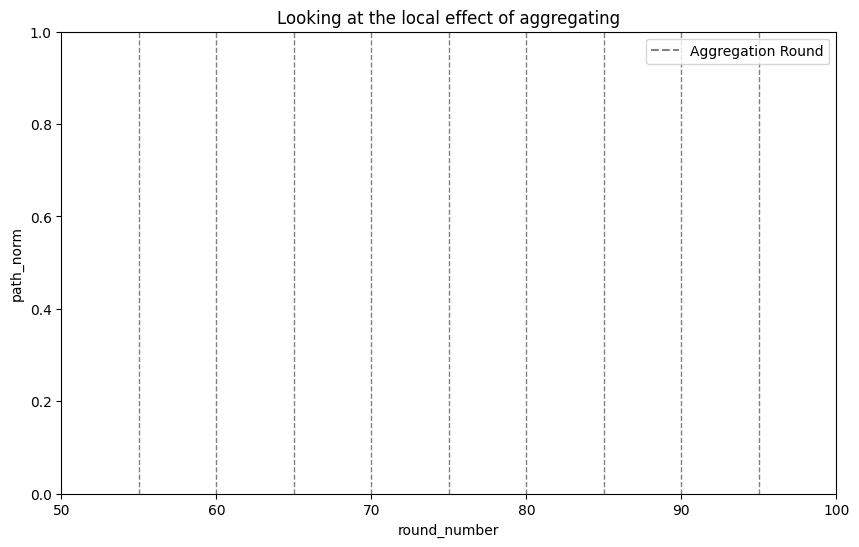

In [68]:
# plt.xlim(40, 150)
# plt.ylim(0, .012)
XLIM = 50
UPPER_LIMIT = 100  # Upper limit for the x-axis zoom
Y_VAR = "path_norm"
filtered_data = df_balanced[(df_balanced['round_number'] > XLIM) & (df_balanced['round_number'] <= UPPER_LIMIT)]
plt.figure(figsize=(10,6))
plt.title("Looking at the local effect of aggregating")
sns.lineplot(data=filtered_data, x='round_number', y=Y_VAR, hue='client_index')
for i in range(BATCHES, len(df_balanced), BATCHES):
    if XLIM < i < UPPER_LIMIT:
        plt.axvline(x=i, linestyle='--', color='grey', linewidth=1)
ax1 = plt.gca()
handles, labels = ax1.get_legend_handles_labels()
custom_line = Line2D([0], [0], color='grey', linestyle='--', label='Aggregation Round')
handles.append(custom_line)
ax1.legend(handles=handles)


plt.xlim(XLIM, UPPER_LIMIT)
plt.ylim(filtered_data[Y_VAR].min(), filtered_data[Y_VAR].max())
plt.show()

ValueError: Axis limits cannot be NaN or Inf

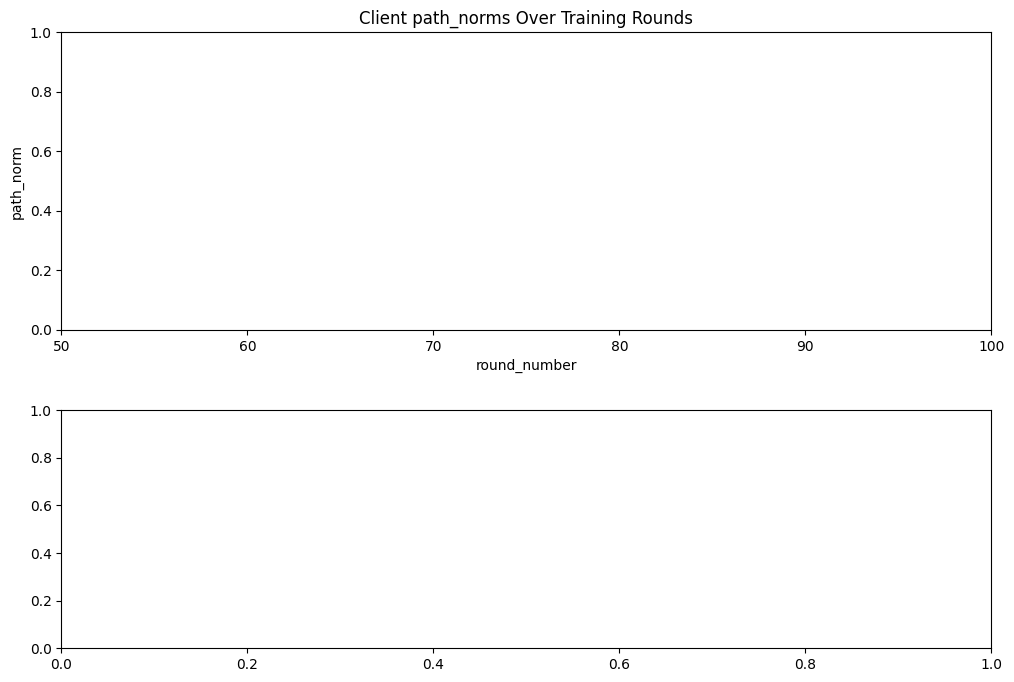

In [69]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[1, 0.8])
plt.subplots_adjust(hspace=0.3)

# Top subplot - Line plot
ax1.set_title(f"Client {Y_VAR}s Over Training Rounds")
sns.lineplot(data=df_balanced[df_balanced['round_number'] > XLIM], 
             x='round_number', y=Y_VAR, 
             hue='client_index', ax=ax1,
            )
ax1.set_xlim(XLIM, UPPER_LIMIT)
ax1.set_ylim(filtered_data[Y_VAR].min(), filtered_data[Y_VAR].max())
for i in range(BATCHES, len(df_balanced), BATCHES):
    if XLIM < i < 150:
        ax1.axvline(x=i, linestyle='--', color='grey', linewidth=1)

custom_line = Line2D([0], [0], color='grey', linestyle='--', label='Aggregation Round')
handles, labels = ax1.get_legend_handles_labels()
handles.append(custom_line)
ax1.legend(handles=handles)
ax1.set_xlabel("epoch round")

clients = df_balanced['client_index'].unique()
class_names = list(client_stats[0]['balance']['class_counts'].keys())
distributions = []

for client in clients:
    dist = [client_stats[client]['balance']['class_frequencies'].get(class_name, 0)
            for class_name in class_names]
    distributions.append(dist)

print(distributions)
sns.heatmap(distributions, 
            annot=True, 
            fmt='.3f',
            cmap='viridis',
            xticklabels=[f'{i}' for i in client_stats[0]['balance']['class_counts'].keys()],
            yticklabels=[f'Client {i}' for i in range(len(clients))],
            # vmin=0, vmax=1,
            ax=ax2)

ax2.set_title("Class Distribution per Client")
ax2.set_xlabel("MNIST Classes (digits '0->9')")
ax2.set_ylabel("Clients")
plt.tight_layout()
plt.show()

In [70]:
df_validations = pd.DataFrame(api.get_validations(session_id=SESSION_ID).get("result"))
df_validations = flatten_nested_dataframe(df_validations)
df_validations = df_validations.drop(["correlation_id", "meta", "sender", "receiver"], axis=1)
df_validations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 19 to 0
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 20 non-null     object             
 1   model_id           20 non-null     object             
 2   session_id         20 non-null     object             
 3   timestamp          20 non-null     datetime64[ns, UTC]
 4   training_loss      20 non-null     float64            
 5   training_accuracy  20 non-null     float64            
 6   test_loss          20 non-null     float64            
 7   test_accuracy      20 non-null     float64            
 8   path_norm          20 non-null     float64            
 9   round_number       20 non-null     int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(3)
memory usage: 1.7+ KB


## Merge global and local calculations

In [71]:
merged_df = merge_federated_rounds(df_balanced, df_validations)
merged_df.head(27)

/tmp/ipykernel_25385/3086318657.py:77: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not pd.api.types.is_datetime64tz_dtype(clients['timestamp']):


,client_index,experiment_id,session_id,epoch,local_train_loss,local_train_accuracy,local_test_loss,local_test_accuracy,local_path_norm,timestamp,round_number,path_norm_pct_change,acc_diff,round_type,id,model_id,global_train_loss,global_train_accuracy,global_test_loss,global_test_accuracy,global_path_norm,absolute_round,cycle
0,0.0,67292bb90fe17824cc25b989,sesh-202411042117,0.0,1.609240,41.312,1.432758,46.30,2.078983,2024-11-04 20:17:50.834045+00:00,0,NaN,-4.988,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
50,1.0,67292bb90fe17824cc25b989,sesh-202411042117,0.0,1.594512,42.132,1.734957,43.22,2.096101,2024-11-04 20:17:52.360964+00:00,0,NaN,-1.088,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,0.0,67292bb90fe17824cc25b989,sesh-202411042117,1.0,1.219970,56.000,1.627780,43.84,2.441647,2024-11-04 20:18:04.278966+00:00,1,0.174443,12.160,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
51,1.0,67292bb90fe17824cc25b989,sesh-202411042117,1.0,1.226710,55.904,1.216302,57.50,2.444943,2024-11-04 20:18:06.240102+00:00,1,0.166424,-1.596,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2,0.0,67292bb90fe17824cc25b989,sesh-202411042117,2.0,1.066713,62.144,1.166656,59.34,2.772630,2024-11-04 20:18:17.771917+00:00,2,0.135558,2.804,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
52,1.0,67292bb90fe17824cc25b989,sesh-202411042117,2.0,1.046031,63.072,1.277715,55.22,2.778305,2024-11-04 20:18:20.398353+00:00,2,0.136347,7.852,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0
3,0.0,67292bb90fe17824cc25b989,sesh-202411042117,3.0,0.950700,66.428,1.058326,63.20,3.122199,2024-11-04 20:18:31.058635+00:00,3,0.126078,3.228,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0
53,1.0,67292bb90fe17824cc25b989,sesh-202411042117,3.0,0.954196,66.648,1.386390,53.68,3.101065,2024-11-04 20:18:34.647790+00:00,3,0.116172,12.968,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0
4,0.0,67292bb90fe17824cc25b989,sesh-202411042117,4.0,0.868525,69.464,1.079529,62.38,3.387891,2024-11-04 20:18:44.338801+00:00,4,0.085098,7.084,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
54,1.0,67292bb90fe17824cc25b989,sesh-202411042117,4.0,0.867153,69.416,1.047586,63.18,3.467145,2024-11-04 20:18:47.073561+00:00,4,0.118050,6.236,local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,0


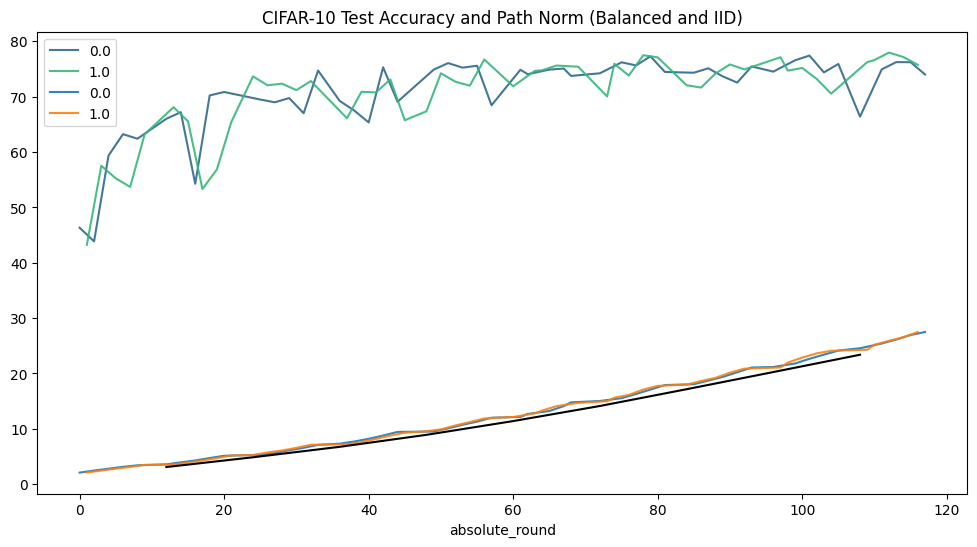

In [75]:
plt.figure(figsize=(12, 6))
# sns.lineplot(data=merged_df[merged_df['round_type'] == 'local'],
#              x='absolute_round', y='local_train_accuracy',
#              hue='client_index', alpha=0.5)
sns.lineplot(data=merged_df[merged_df['round_type'] == 'local'],
             x='absolute_round', y='local_test_accuracy',
             hue='client_index', alpha=0.9, palette="viridis")
sns.lineplot(data=merged_df[merged_df['round_type'] == 'local'],
             x='absolute_round', y='local_path_norm',
             hue='client_index', alpha=0.9)
sns.lineplot(data=merged_df[merged_df['round_type'] == 'local'].drop_duplicates(subset=['global_path_norm']),
             x='absolute_round', y='global_path_norm',
             color="black")
# sns.lineplot(data=merged_df[merged_df['round_type'] == 'global'],
#              x='absolute_round', y='global_train_accuracy',
#              color='black', linewidth=1)
plt.title('CIFAR-10 Test Accuracy and Path Norm (Balanced and IID)')
plt.ylabel("")
plt.show()

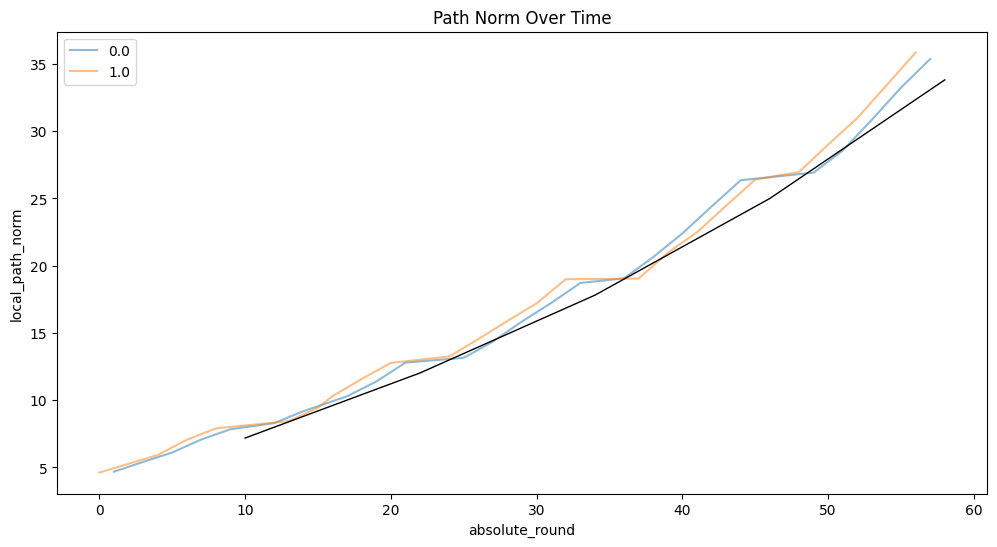

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df[merged_df['round_type'] == 'local'],
             x='absolute_round', y='local_path_norm',
             hue='client_index', alpha=0.5)
sns.lineplot(data=merged_df[merged_df['round_type'] == 'global'].drop_duplicates(subset=['global_path_norm']),
             x='absolute_round', y='global_path_norm',
             color='black', linewidth=1)
plt.title('Path Norm Over Time')
plt.show()


Summary Statistics:

Mean Differences (Global - Local):
client_index
0.0   -4.445016
1.0   -4.590048
Name: path_norm_diff, dtype: float64

Mean Percent Changes:

Local (by client):
client_index
0.0    8.844339
1.0    8.976622
Name: local_pct_change, dtype: float64

Global:
47.75669274532939


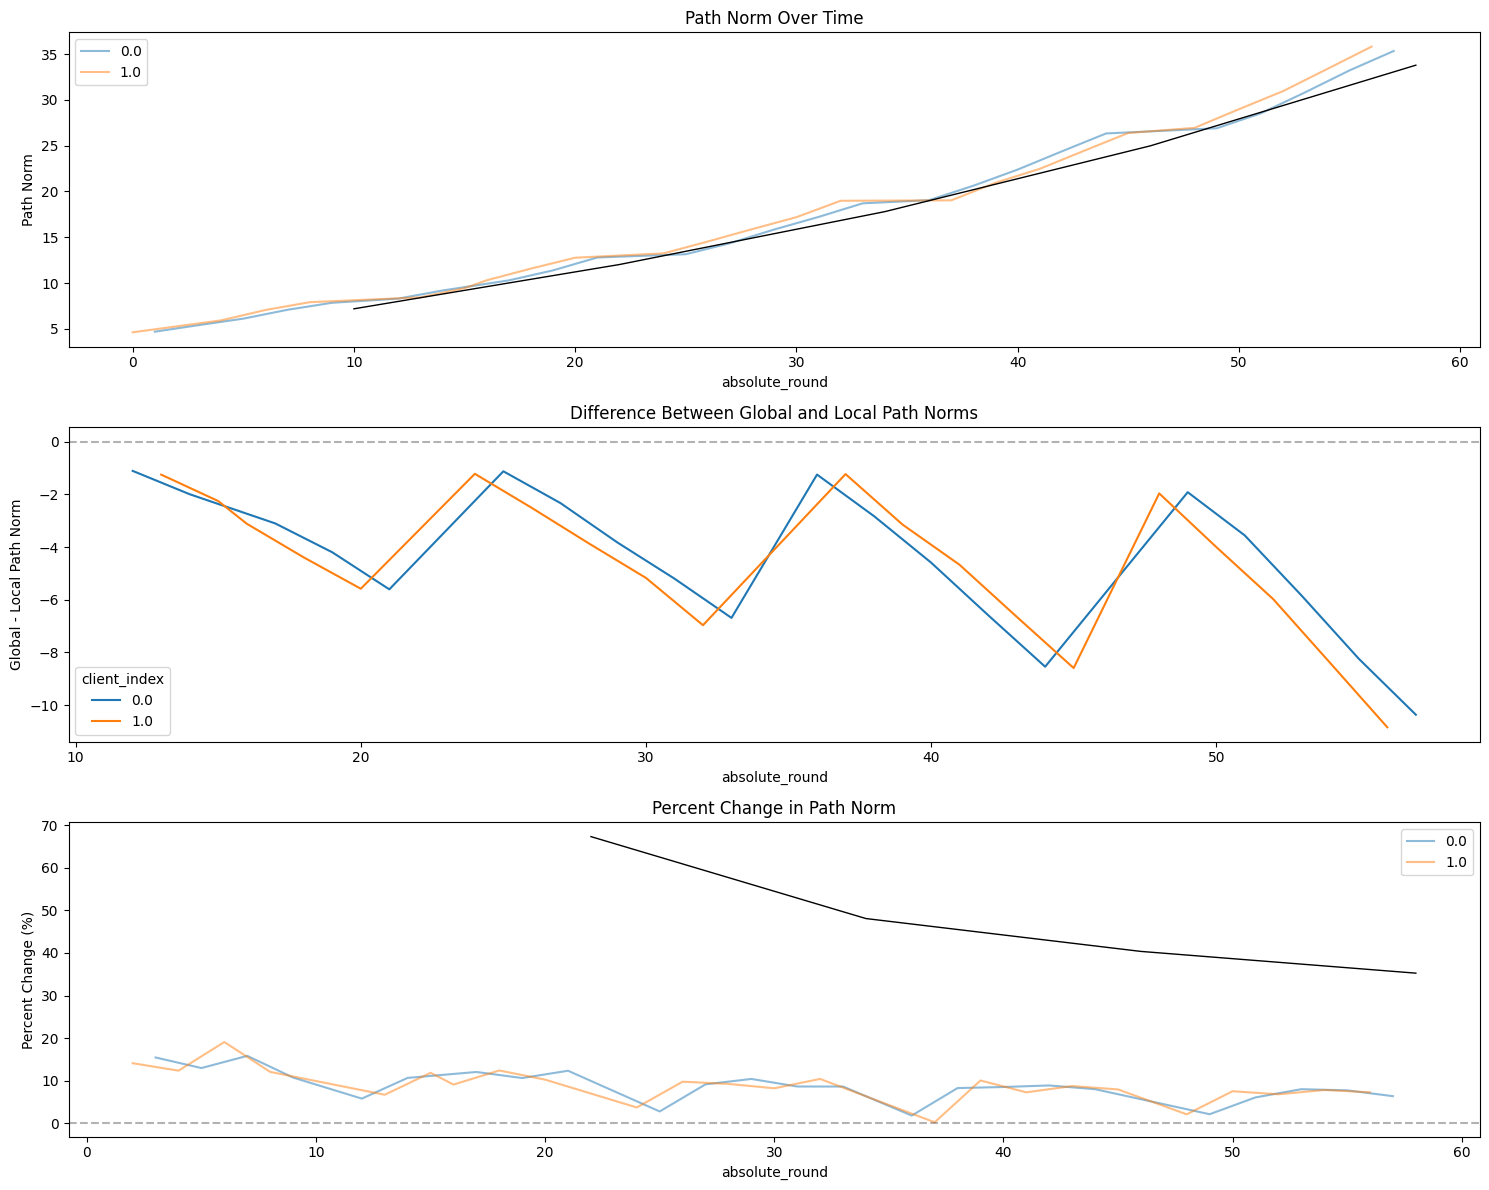

In [61]:
plot_path_norm_analysis(merged_df)
plt.show()

In [65]:
temp_c0 = df_balanced[df_balanced["client_index"] == 0].dropna()
temp_c1 = df_balanced[df_balanced["client_index"] == 1].dropna()
print("Correlation Client 0")
print(np.corrcoef(temp_c0['acc_diff'], temp_c0['path_norm_pct_change']))
print("Correlation Client 1")
print(np.corrcoef(temp_c1['acc_diff'], temp_c1['path_norm_pct_change']))

Correlation Client 0
[[ 1.         -0.92401078]
 [-0.92401078  1.        ]]
Correlation Client 1
[[ 1.         -0.94243553]
 [-0.94243553  1.        ]]
